In [167]:
%matplotlib inline
import sys
from scipy import stats
from collections import defaultdict, Counter
from scipy import spatial
import datetime
import numpy as np
import pylab as plt
import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from sklearn.manifold import TSNE
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
import matplotlib
from numpy.random import choice
import itertools
import operator
from sklearn import manifold
import pandas as pd
from sklearn.cluster import KMeans
import statsmodels.api as sm


def OLSRegressFit(x,y): # fitting regression 
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

def flushPrint(d): # counter
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()
    
def default_to_regular(d): # convert default dict to regular dict
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def convert(s): return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

# 1. Time Series 

In [170]:
# H1B 5-year data downloaded from https://www.kaggle.com/nsharan/h-1b-visa/version/2
#
# see https://sharan-naribole.github.io/2017/02/24/h1b-eda-part-I.html for data cleaning
# and https://github.com/sharan-naribole/H1B_visa_eda/blob/master/data_processing.Rmd
# for more informtation on this dataset, and 
# https://quanwei.tech/ for an online version

df0=pd.read_csv("/Users/lingfeiw/Documents/teaching/INFOVIZ/futureHacking/h1b_kaggle.csv",
               header='infer',delimiter=",",encoding = "ISO-8859-1")
df0=df0.dropna() # this drop rows with nan values in any column, for formal analysis do it for specifici columns

In [171]:
df0.columns

Index(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'lon',
       'lat'],
      dtype='object')

In [172]:
len(df0)

2877765

## 1.1 How large is the H1B pool?

In [173]:
S=defaultdict(lambda:defaultdict(lambda:0))
for y,s in zip(df0['YEAR'],df0['CASE_STATUS']):
    S[s.lower()][int(y)]+=1
    
status=list(S.keys())
# In analysis we find 'rejected', 'invalidated', and 'pending quality and compliance review - unassigned' 
# are very rare, therefore, we would not visualize them

### 1.1.1 Line Chart

#### 1.1.1.1 Simple Lines of Different Symbols

(0, 600000)

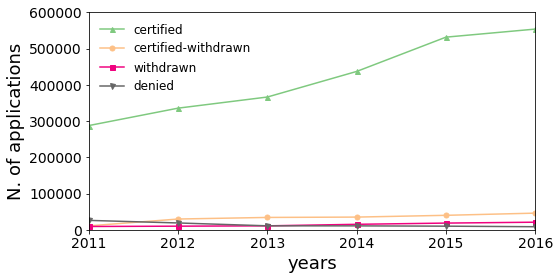

In [174]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for i,j in zip(['certified','certified-withdrawn','withdrawn','denied'],['^','o','s','v']):
    x,y=np.array(sorted(S[i].items())).T
    plt.plot(x,y,color=cmap(n),label=i,marker=j,markersize=5)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(2011,2016)
plt.ylim(0,600000)

#### 1.1.1.2 Simple Lines with Color Filling

(0, 600000)

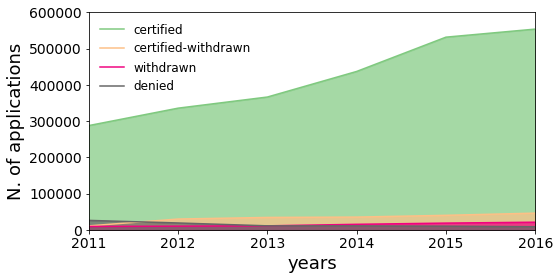

In [175]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for i in ['certified','certified-withdrawn','withdrawn','denied']:
    x,y=np.array(sorted(S[i].items())).T
    plt.plot(x,y,color=cmap(n),label=i,marker='',markersize=5)
    plt.fill_between(x,y,color=cmap(n),alpha=0.7)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(2011,2016)
plt.ylim(0,600000)

#### 1.1.1.3 Simple Lines with Log-log Axes 

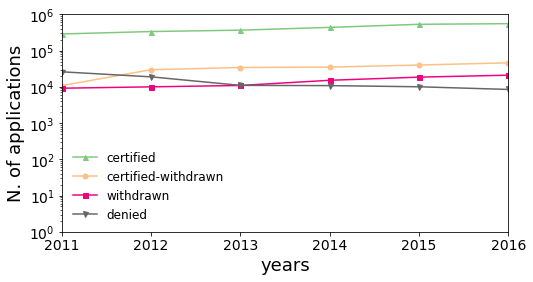

In [176]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for i,j in zip(['certified','certified-withdrawn','withdrawn','denied'],['^','o','s','v']):
    x,y=np.array(sorted(S[i].items())).T
    plt.plot(x,y,color=cmap(n),label=i,marker=j,markersize=5)
    n+=1
ax.legend(loc=3,numpoints=1,fontsize=12,frameon=False)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(2011,2016)
plt.ylim(1,1000000)
plt.yscale('log')

### 1.1.2 Bar Chart

#### 1.1.2.1 Bars of Different Colors

(0, 600000)

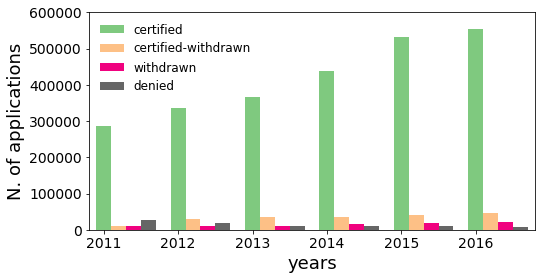

In [177]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
deltaX=0.2
n=0
for i in ['certified','certified-withdrawn','withdrawn','denied']:
    x,y=np.array(sorted(S[i].items())).T
    ax.bar(x+deltaX*n,y,width=deltaX,color=cmap(n),label=i)
    n+=1
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlim(2010.8,2016.8)
plt.ylim(0,600000)

#### 1.1.2.2 Bars of Different Colors - Stacked

(0, 600000)

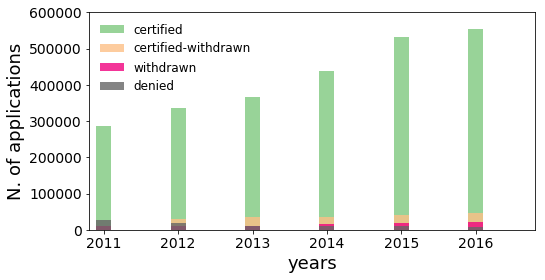

In [178]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
deltaX=0.2
n=0
for i in ['certified','certified-withdrawn','withdrawn','denied']:
    x,y=np.array(sorted(S[i].items())).T
    ax.bar(x,y,width=deltaX,color=cmap(n),label=i,alpha=0.8)
    n+=1
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlim(2010.8,2016.8)
plt.ylim(0,600000)

#### 1.1.2.3 Bars of Different Hatches

(0, 600000)

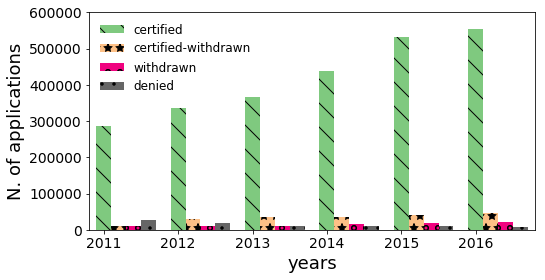

In [179]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
deltaX=0.2
n=0
for i,j in zip(['certified','certified-withdrawn','withdrawn','denied'],[ '\\','*', 'o',  '.']):
    x,y=np.array(sorted(S[i].items())).T
    ax.bar(x+deltaX*n,y,width=deltaX,color=cmap(n),label=i,hatch=j)
    n+=1
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlim(2010.8,2016.8)
plt.ylim(0,600000)

## 1. 2 What kinds of jobs are more likely to get a H1B visa?

In [186]:
## aggregate to major groups 
## from  https://www.bls.gov/soc/2018/major_groups.htm
SO={
11:"Management Occupations",
13:"Business and Financial Operations Occupations",
15:"Computer and Mathematical Occupations",
17:"Architecture and Engineering Occupations",
19:"Life, Physical, and Social Science Occupations",
21:"Community and Social Service Occupations",
23:"Legal Occupations",
25:"Educational Instruction and Library Occupations",
27:"Arts, Design, Entertainment, Sports, and Media Occupations",
29:"Healthcare Practitioners and Technical Occupations",
31:"Healthcare Support Occupations",
33:"Protective Service Occupations",
35:"Food Preparation and Serving Related Occupations",
37:"Building and Grounds Cleaning and Maintenance Occupations",
39:"Personal Care and Service Occupations",
41:"Sales and Related Occupations",
43:"Office and Administrative Support Occupations",
45:"Farming, Fishing, and Forestry Occupations",
47:"Construction and Extraction Occupations",
49:"Installation, Maintenance, and Repair Occupations",
51:"Production Occupations",
53:"Transportation and Material Moving Occupations",
55:"Military Specific Occupations"
}

# grouping SOC jobs
# you can download it from 
#https://github.com/lingfeiwu/futureHackingDemo/blob/master/rank_probability_label_soc_occupation.txt


group={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/rank_probability_label_soc_occupation.txt','r') as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        s=int(jobcode.split('-')[0])
        if s in SO:
            group[jobname.lower()]=SO[s]

In [180]:
O=defaultdict(lambda:defaultdict(lambda:0))#  job: year: N of certified
for y,j,f,s in zip(df0['YEAR'],df0['SOC_NAME'],df0['FULL_TIME_POSITION'],df0['CASE_STATUS']):
    if f=='Y':#full time
        s=s.lower()
        if s=='certified':
            j=j.lower()
            O[j][y]+=1
OY={k:int(np.mean(list(v.values()))) for k,v in O.items()}# averaged by year

In [181]:
sorted(OY.items(),key=lambda x:-x[1])[:5]

[('computer systems analysts', 67307),
 ('software developers, applications', 54031),
 ('computer programmers', 48638),
 ('computer occupations, all other', 33697),
 ('software developers, systems software', 11685)]

In [182]:
sorted(OY.items(),key=lambda x:-x[1])[-5:]

[('bus and truck mechanics and diesel engine speciali', 1),
 ('insurance appraisers, auto damage', 1),
 ('team assemblers', 1),
 ('tree trimmers and pruners', 1),
 ('excavating and loading machine and dragline operat', 1)]

In [183]:
# computerization risk score from frey&Osborne 2013
P={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/rank_probability_label_soc_occupation.txt','r') as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        P[jobname.lower()]=float(pro)
len(P)

702

### 1.2.1 Regression Plot

In [184]:
# define regression function
def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

In [331]:
automation_risk,size=np.array([(P[i],OY[i]) for i in P if i in OY and OY[i]>0]).T

In [332]:
constant, beta, r2=OLSRegressFit(automation_risk,np.log(size))
constant, beta, r2

(4.4774212734528955, -3.6616561975313306, 0.2715935038820778)

In [333]:
pearsonr(automation_risk,np.log(size))

(-0.5211463363414137, 5.531324424758438e-28)

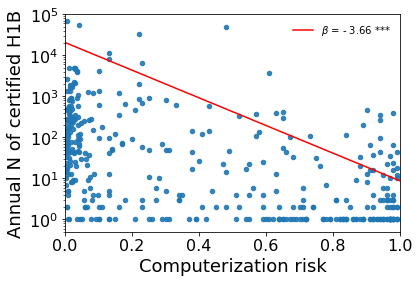

In [359]:
fig = plt.figure(figsize=(6, 4),facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(automation_risk,size,s=20,alpha=0.9)
xs=np.linspace(0,1,100)
plt.plot(xs,np.exp(constant+xs*beta),'r-',label=r'$\beta$'+' = - 3.66 ***')
plt.legend(loc=1,frameon=False,fontsize=10,numpoints=1)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(.5,10**5)
plt.xlabel('Computerization risk',fontsize=18)
plt.ylabel('Annual N of certified H1B',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

In [188]:
# computerization risk by job groups
X=defaultdict(lambda:[])
for k,v in group.items():
    if k in P:
        X[v].append(P[k])
PG=dict((k,np.mean(v)) for k,v in X.items())

In [189]:
OC=defaultdict(lambda:0)#  
for k,v in OY.items():
    if k in group:
        OC[group[k]]+=v

In [344]:
automation_Risk,Size=np.array([(PG[i],OC[i]) for i in PG]).T

In [345]:
constant, beta, r2=OLSRegressFit(automation_Risk,np.log(Size))
constant, beta, r2

(9.92962670397161, -7.761273440300369, 0.41129894955407365)

In [346]:
pearsonr(automation_Risk,np.log(Size))

(-0.6413259308293044, 0.0012969604200321614)

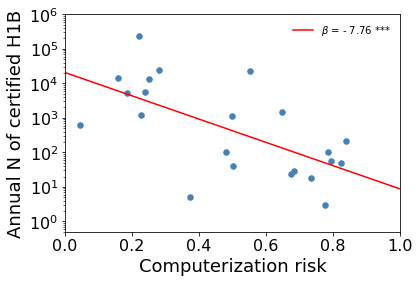

In [356]:
fig = plt.figure(figsize=(6, 4),facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(automation_Risk,Size,facecolor='SteelBlue',edgecolor='SteelBlue',s=30,zorder=1)
xs=np.linspace(0,1,100)
plt.plot(xs,np.exp(constant+xs*beta),'r-',label=r'$\beta$'+' = - 7.76 ***',zorder=2)
plt.legend(loc=1,frameon=False,fontsize=10,numpoints=1)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(.5,10**6)
plt.xlabel('Computerization risk',fontsize=18)
plt.ylabel('Annual N of certified H1B',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

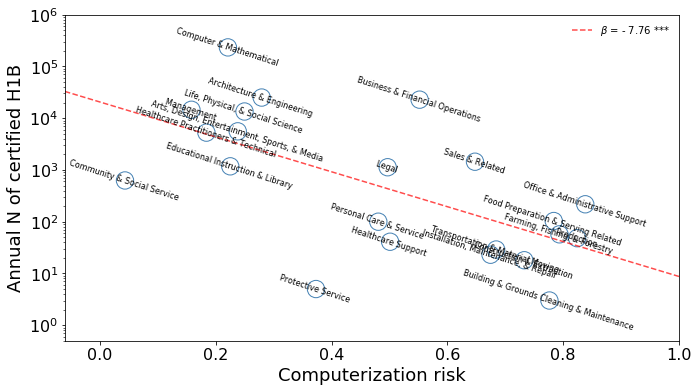

In [366]:
fig = plt.figure(figsize=(11, 6),facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(automation_Risk,Size,facecolor='',edgecolor='SteelBlue',s=300)
for i in PG:
    x,y=(PG[i],OC[i])
    name=i.replace('Occupations','').replace('and','&')
    plt.text(x,y,name,ha='center',va='center',size=8,
             rotation=-18,rotation_mode='anchor')
xs=np.linspace(-.1,1,100)
plt.plot(xs,np.exp(constant+xs*beta),'r--',label=r'$\beta$'+' = - 7.76 ***',alpha=.7)
plt.legend(loc=1,frameon=False,fontsize=10,numpoints=1)
plt.yscale('log')
plt.xlim(-.06,1)
plt.ylim(.5,10**6)
plt.xlabel('Computerization risk',fontsize=18)
plt.ylabel('Annual N of certified H1B',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

### 1.2.2 Simple Lines with Grids

In [369]:
OCY=defaultdict(lambda:defaultdict(lambda:0))#  
for j,d in O.items():
    if j in group:
        c=group[j]
    for y,v in d.items():
        OCY[c][y]+=v

In [371]:
len(OCY)

22

In [377]:
OCK={}
for i in OCY:
    ys=[]
    for y in range(2011,2017):
        if y in OCY[i].keys():# because we used defaultdict here
            ys.append(OCY[i][y])
        else:
            ys.append(0)
    OCK[i]=ys

### 1.2.1 Simple Lines with Grids

In [385]:
sorted_group=list(zip(*sorted(OC.items(),key=lambda x:-x[1])))[0]

(2011, 2016)

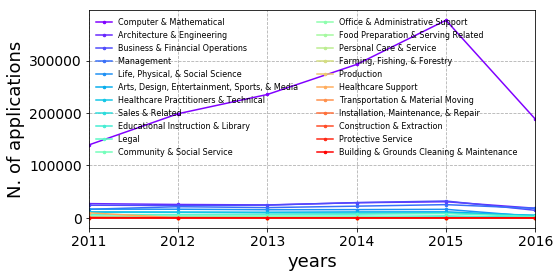

In [400]:
cmap = cm.get_cmap('rainbow',len(OCK))
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for i in sorted_group:
    ys=OCK[i]
    name=i.replace('Occupations','').replace('and','&')
    plt.plot(range(2011,2017),ys,color=cmap(n),label=name,marker='.',markersize=5)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=8,frameon=False,ncol=2)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.grid(linestyle='--')
plt.xlim(2011,2016)
#plt.ylim(0,60000)

## 1.3 How long it takes to get H1B ?

In [194]:
# decision date info download from 
##https://www.foreignlaborcert.doleta.gov/performancedata.cfm
# see here for variable dictionary 
# https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2018/PERM_FY18_Record_Layout.pdf

xl = pd.ExcelFile("/Users/lingfeiw/Documents/teaching/INFOVIZ/futureHacking/PERM_Disclosure_Data_FY2018_EOY.xlsx")
df = xl.parse("PERM_FY2018")

In [6]:
df.columns

Index(['CASE_NUMBER', 'DECISION_DATE', 'CASE_STATUS', 'CASE_RECEIVED_DATE',
       'REFILE', 'ORIG_FILE_DATE', 'ORIG_CASE_NO', 'SCHD_A_SHEEPHERDER',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS_1',
       ...
       'FW_INFO_TRAINING_COMP', 'FW_INFO_REQ_EXPERIENCE',
       'FW_INFO_ALT_EDU_EXPERIENCE', 'FW_INFO_REL_OCCUP_EXP',
       'PREPARER_INFO_EMP_COMPLETED', 'PREPARER_INFO_TITLE',
       'EMPLOYER_DECL_INFO_TITLE', 'NAICS_US_CODE', 'NAICS_US_TITLE',
       'PW_JOB_TITLE_9089'],
      dtype='object', length=125)

In [4]:
len(df)

119776

In [7]:
timeStamp=[]
for a,b,s,r in zip(df['CASE_RECEIVED_DATE'],df['DECISION_DATE'],df['CASE_STATUS'],df['REFILE']):
    if r=='N' and s=='Certified':
        timeStamp.append([a,b])
len(timeStamp)

72151

In [8]:
starts,ends=list(zip(*timeStamp))
fileTimeX,fileTimeY=list(zip(*Counter(starts).items()))
approvalTimeX,approvalTimeY=list(zip(*Counter(ends).items()))


### 1.3.1 Bar Chat

(0, 1800)

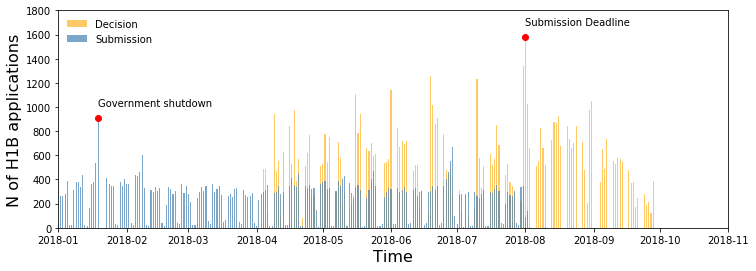

In [9]:
# US government shutdown list 
# https://en.wikipedia.org/wiki/Government_shutdowns_in_the_United_States

fig = plt.figure(figsize=(12, 4),facecolor='white')
#
ax = fig.add_subplot(111)
#
ax.bar(approvalTimeX,approvalTimeY, width=.5,color='Orange',label='Decision',alpha=.6)
plt.xlim(convert('2018-01-01 00:00:00'),convert('2018-11-01 00:00:00'))# approval comes after 04-01


ax.bar(fileTimeX,fileTimeY, width=.5,color='SteelBlue',label='Submission',alpha=.7)
plt.xlim(convert('2018-01-01 00:00:00'),convert('2018-11-01 00:00:00'))# deadline in 08-01
#

#
for x,y in zip(fileTimeX,fileTimeY):
    if y>800:
        plt.plot(x,y,'ro')
        plt.text(x,y+100,'Government shutdown')
for x,y in zip(approvalTimeX,approvalTimeY):
    if y>1500:
        plt.plot(x,y,'ro')
        plt.text(x,y+100,'Submission Deadline')
#
plt.legend(loc=2,frameon=False)
plt.xlabel('Time',fontsize=16)
plt.ylabel('N of H1B applications',fontsize=16)
#
plt.ylim(0,1800)

### 1.3.2 Time Wheel

In [105]:
# generate the table with timestamps
days = pd.Series([pd.to_datetime('2018-01-01 00:00:00', format='%Y-%m-%d %H:%M:%S') + 
           pd.to_timedelta(i, unit='d') for i in range(366)])
data = pd.crosstab(days.dt.weekday, times.dt.month).fillna(0)
data = data - data# we only need the format
#
de=pd.DataFrame([(i.weekday(),i.month) for i in ends])
de.columns=['wd','mo']
detable=pd.crosstab(de['wd'],de['mo'], margins=False)
detable=data+detable
detable=detable.fillna(0)
detable.rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}, inplace=True)

In [106]:
detable

,1,2,3,4,5,6,7,8,9,10,11,12
Monday,0.0,0.0,0.0,2800.0,1144.0,2204.0,1741.0,2798.0,1308.0,0.0,0.0,0.0
Tuesday,0.0,0.0,0.0,1617.0,2679.0,2923.0,3746.0,2649.0,1461.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,2792.0,3707.0,2688.0,1525.0,4138.0,1815.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,1237.0,2682.0,2202.0,1801.0,4274.0,1354.0,0.0,0.0,0.0
Friday,0.0,0.0,0.0,1602.0,2614.0,3336.0,1583.0,3751.0,1903.0,0.0,0.0,0.0
Saturday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sunday,0.0,0.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# make a heatmap building function 
def pie_heatmap(table, cmap=cm.hot_r, vmin=None, vmax=None,inner_r=0.25):
    n, m = table.shape
    vmin= table.min().min() if vmin is None else vmin
    vmax= table.max().max() if vmax is None else vmax

    centre_circle = plt.Circle((0,0),inner_r,edgecolor='black',facecolor='white',fill=True,linewidth=0.25)
    plt.gcf().gca().add_artist(centre_circle)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i, (row_name, row) in enumerate(table.iterrows()):
        labels = None if i > 0 else table.columns 
        wedges = plt.pie([1] * m,radius=inner_r+float(n-i)/n, colors=[cmapper.to_rgba(x) for x in row.values], 
            labels=labels, startangle=90, counterclock=False, wedgeprops={'linewidth':-1}, 
                         textprops={'fontsize': 14,'color':'k'})
        plt.setp(wedges[0], edgecolor='gray',linewidth=.3,linestyle='-.',alpha=0.8)
        wedges = plt.pie([1], radius=inner_r+float(n-i-1)/n, colors=['w'], labels=[row_name], 
                         startangle=-90, wedgeprops={'linewidth':0})
        plt.setp(wedges[0], edgecolor='gray',linewidth=.3,linestyle='-.',alpha=0.8)
        

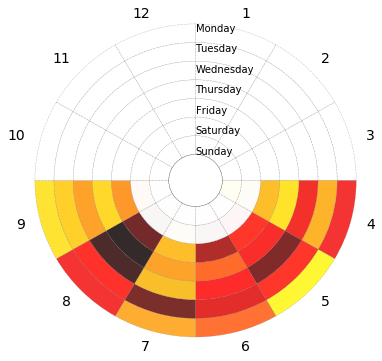

In [163]:
plt.figure(figsize=(6,6))
pie_heatmap(detable,inner_r=0.2,)
plt.show();

In [136]:
# generate the table with timestamps
days = pd.Series([pd.to_datetime('2018-01-01 00:00:00', format='%Y-%m-%d %H:%M:%S') + 
           pd.to_timedelta(i, unit='d') for i in range(366)])
data = pd.crosstab(days.dt.weekday, times.dt.month).fillna(0)
data = data - data# we only need the format
#
su=pd.DataFrame([(i.weekday(),i.month) for i in starts])
su.columns=['wd','mo']
sutable=pd.crosstab(su['wd'],su['mo'], margins=False)
sutable=data+sutable
sutable=sutable.fillna(0)
sutable.rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}, inplace=True)

In [138]:
sutable

col_0,1,2,3,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,,,
Monday,886,1301,1195,1575,872,1292,1435,162,128,299,1387,1341
Tuesday,1771,1362,1163,1334,1579,1347,1496,268,240,471,1391,1538
Wednesday,1802,1475,1170,1357,1780,1394,877,302,272,296,1589,1527
Thursday,1523,1552,1517,1251,1898,1513,1196,393,216,322,1367,1896
Friday,2094,1333,1459,1441,1415,1966,1252,206,280,338,1083,2215
Saturday,77,144,221,197,53,202,117,11,12,31,112,158
Sunday,58,83,158,79,414,146,117,12,35,32,100,182


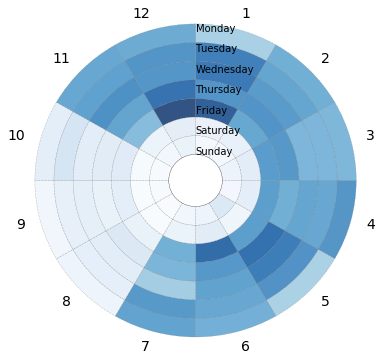

In [164]:
plt.figure(figsize=(6,6))
pie_heatmap(sutable,cmap=plt.cm.Blues,inner_r=0.2,)
plt.show();

In [172]:
## durations!
ds=[(b-a).days for a,b in timeStamp]

In [196]:
min(ds),max(ds),np.mean(ds),np.median(ds)

(28, 3588, 123.00945239844215, 111.0)

### 1.3.3 Time Distribution

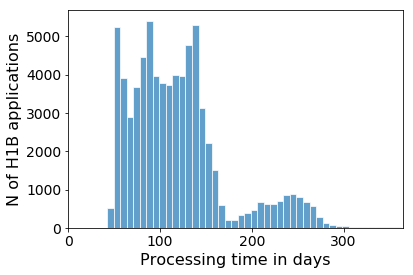

In [194]:
fig = plt.figure(figsize=(6, 4),facecolor='white')
#
ax = fig.add_subplot(111)
plt.hist(ds,500,edgecolor='white',alpha=0.7)
plt.xlim(0,365)
#plt.legend(loc=2,frameon=False)
plt.xlabel('Processing time in days',fontsize=16)
plt.ylabel('N of H1B applications',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
#
plt.show()

## 1.4 Are there seasonal changes across wage/education levels?

### 1.4.1 Simple Line Plot

In [61]:
dd={'High School':0,"Associate's":1,"Bachelor's":2,"Master's":3,'Doctorate':4}
rdd=dict((v, k) for k, v in dd.items())
degreeSeason=defaultdict(lambda:defaultdict(lambda:0))
for a,d,s,r in zip(df['CASE_RECEIVED_DATE'],df['JOB_INFO_EDUCATION'],df['CASE_STATUS'],df['REFILE']):
    if r=='N' and s=='Certified' and d in dd:
        j=dd[d]
        degreeSeason[j][a]+=1
            
len(degreeSeason)

5

In [62]:
days = pd.Series([pd.to_datetime('2018-01-01 00:00:00', format='%Y-%m-%d %H:%M:%S') + 
           pd.to_timedelta(i, unit='d') for i in range(366)])
degreeData=[]
for i in range(5):
    s=[]
    for j in days:
        if j in degreeSeason[i].keys():
            s.append(degreeSeason[i][j])
        else:
            s.append(0.1)# filling zero value
    degreeData.append(s)

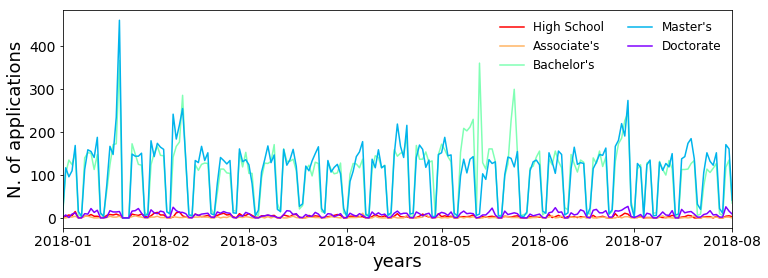

In [67]:

fig = plt.figure(figsize=(12, 4),facecolor='white')
cmap = cm.get_cmap('rainbow_r',len(degreeData))
ax = fig.add_subplot(111)
n=0
for i in range(5):
    ys=degreeData[i]
    name=rdd[i]
    plt.plot(days,ys,linewidth=1.5,color=cmap(n),label=name,marker='',markersize=5)
    n+=1
ax.legend(loc=1,numpoints=1,fontsize=12,frameon=False,ncol=2)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(convert('2018-01-01 00:00:00'),convert('2018-08-01 00:00:00'))# deadline in 08-01
plt.xticks(rotation=0)# rotate if too dense
plt.show()
#plt.grid(linestyle='--')
#plt.xlim(2011,2016)
#plt.ylim(0,60000)

In [35]:
pay=[float(i.replace(',','')) for i in df['PW_AMOUNT_9089'].dropna() if i!='#############']

In [50]:
min(pay),max(pay),np.median(pay)

(7.25, 6262900.0, 90813.0)

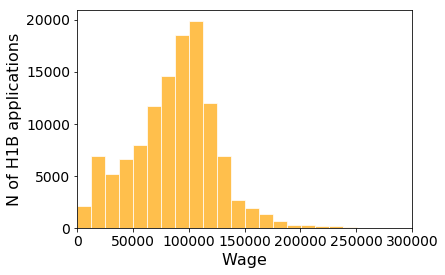

In [58]:
fig = plt.figure(figsize=(6, 4),facecolor='white')
#
ax = fig.add_subplot(111)
plt.hist(pay,500,facecolor='Orange',edgecolor='white',alpha=0.7)
plt.xlim(0,300000)
plt.xlabel('Wage',fontsize=16)
plt.ylabel('N of H1B applications',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [74]:
def payCode(s): 
    if s<=50000:
        return 0
    if 50000<s<=100000:
        return 1
    if 100000<s<=150000:
        return 2
    if 150000<s<=200000:
        return 3
    if 200000<s:
        return 4

In [88]:

wageSeason=defaultdict(lambda:defaultdict(lambda:0))
for a,p,s,r in zip(df['CASE_RECEIVED_DATE'],df['PW_AMOUNT_9089'],df['CASE_STATUS'],df['REFILE']):
    if r=='N' and s=='Certified' and p!='#############':
        if ',' in p:
            p=float(p.replace(',',''))
            if p>0:
                wageSeason[payCode(p)][a.week]+=1
            
len(wageSeason)

5

In [89]:
wageData=[]
for i in range(5):
    s=[]
    for j in range(53):
        if j in wageSeason[i].keys():
            s.append(wageSeason[i][j])
        else:
            s.append(0.1)# filling zero value
    wageData.append(s)

In [103]:
wD={0:'$0-$50k',1:'$50k-$10k',2:'$10k-$15k',3:'$15k-$20k',4:'>$20k'}

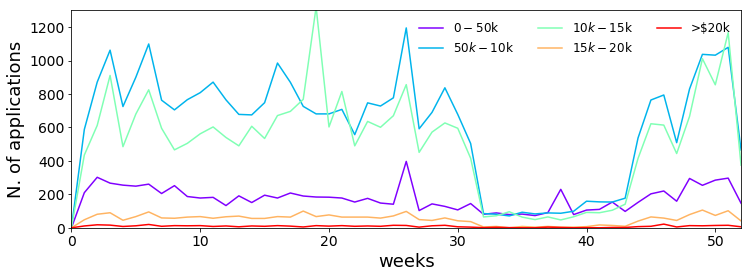

In [115]:
fig = plt.figure(figsize=(12, 4),facecolor='white')
cmap = cm.get_cmap('rainbow',5)
ax = fig.add_subplot(111)
n=0
for i in range(5):
    ys=wageData[i]
    #name=rdd[i]
    plt.plot(range(53),ys,linewidth=1.5,color=cmap(n),label=wD[i],marker='',markersize=5)
    n+=1
ax.legend(loc=1,numpoints=1,fontsize=12,frameon=False,ncol=3)
plt.xlabel('weeks',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.xlim(convert('2018-01-01 00:00:00'),convert('2018-08-01 00:00:00'))# deadline in 08-01
plt.xticks(rotation=0)# rotate if too dense
#plt.grid(linestyle='--')
plt.xlim(0,52)
plt.ylim(0,1300)
plt.show()

### 1.4.2 Stack Plot

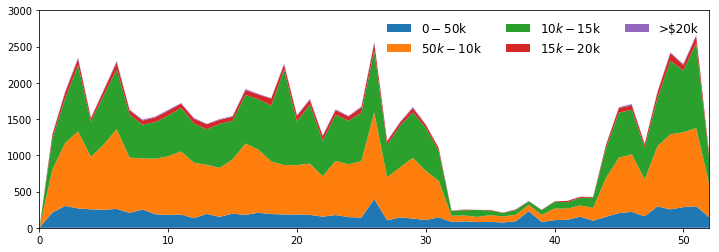

In [153]:
fig = plt.figure(figsize=(12, 4),facecolor='white')
ax = fig.add_subplot(111)
ax.stackplot(range(53), wageData[0], wageData[1], wageData[2], wageData[3], wageData[4], labels=list(wD.values()))
ax.legend(loc=1,numpoints=1,fontsize=12,frameon=False,ncol=3)
plt.xlim(0,52)
plt.ylim(0,3000)
plt.show()
plt.show()

### 1.4.3 Theme River

(0, 52)

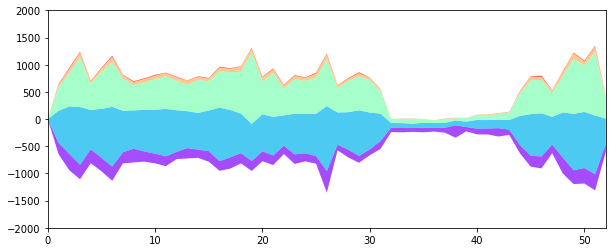

In [141]:
fig = plt.figure(figsize=(10, 4),facecolor='white')
ax = fig.add_subplot(111)
streamgraph(ax,wageData)
plt.ylim(-2000,2000)
plt.xlim(0,52)

In [140]:
# from http://leebyron.com/streamgraph/stackedgraphs_byron_wattenberg.pd
# Based on http://code.activestate.com/recipes/576633/
# which is based on:
# Reference: 'Stacked graphs- geometry & aesthetics' by Byron and Wattenberg
# http://www.leebyron.com/else/streamgraph/download.php?file=stackedgraphs_byron_wattenberg.pdf

import numpy as np
import matplotlib.pyplot as plt

# baseline functions
def baseline_symmetric(streams):
    """Symmetric baseline ('silhouette')"""
    g0 = -0.5 * np.sum(np.asarray(streams),axis=0)
    return g0

def baseline_zero(streams):
    """Zero baseline"""
    return np.zeros(np.asarray(streams).shape[1])

def baseline_weighted_wiggle(streams):
    """Weighted-wiggle minimization
    
    NOTE: streams should already be ordered as desired
    """
    streams = np.asarray(streams)
    
    # add a column of zeros on the left side of streams
    f = np.hstack( (np.zeros((streams.shape[0],1)),streams) )
    dff = np.diff(f)
    cum_sum_dff = np.vstack( (np.zeros((1,dff.shape[1])),np.cumsum(dff,axis=0)) )[:-1,:]
    dg0 = (-1./np.sum(streams,axis=0)) * np.sum((0.5 * dff + cum_sum_dff) * streams,axis=0)
    g0 = np.cumsum(dg0)
    return g0

# ordering functions
def argsort_onset(streams):
    """Returns permutation indices (like argsort) for onset ordering."""
    streams = np.asarray(streams)
    nonzero_idxs = [np.arange(streams.shape[1])[idxs] for idxs in (streams > 0)]
    onset_idxs = [np.min(nzi) if len(nzi) > 0 else streams.shape[1] for nzi in nonzero_idxs]
    return np.argsort(onset_idxs)

def argsort_inside_out(streams):
    """Returns permutation indices (like argsort) for inside-out ordering."""
    upper = []
    lower = []
    weight_up = 0
    weight_lo = 0
    for (i,stream) in enumerate(streams):
        if weight_up < weight_lo:
            upper.append(i)
            weight_up += np.sum(stream)
        else:
            lower.append(i)
            weight_lo += np.sum(stream)
    
    return upper[::-1] + lower

def streamgraph(ax, streams, x=None, colors=None, baseline=baseline_weighted_wiggle, yoffset=0., whitebg=True):
    streams = np.asarray(streams)
    
    g0 = baseline(streams) + yoffset
    
    if x == None:
        x = range(streams.shape[1])
    
    if colors == None:
        cmap = cm.get_cmap('rainbow',streams.shape[0])
        #colors = list(map(cm.get_cmap('rainbow'),np.random.uniform(size=streams.shape[0])))
        colors=[cmap(i) for i in range(streams.shape[0])]
    
    layers = []
    g_lo = g0
    for stream in streams:
        g_hi = g_lo + stream
        verts_lo = list(zip(x,g_lo))
        verts_hi = list(zip(x[::-1],g_hi[::-1]))
        layer = verts_lo + verts_hi
        layers.append(layer)
        g_lo = g_hi
    
    polys = matplotlib.collections.PolyCollection(
        layers,facecolors=colors,alpha=0.7,linewidths=0, zorder=0)
    ax.add_collection(polys)
    
#     # add an opaque white background to the streamgraph
#     if whitebg == True:
#         verts = np.asarray(list(zip(x,g0)) + list(zip(x[::-1],g_hi[::-1])))
#         bglayer = mpl.patches.Polygon(verts, closed=True, color='white', alpha=1, zorder=5)
#         ax.add_patch(bglayer)
    
    return ax

def format_streamgraph(ax):
    """Performs some common formatting operations for streamgraphs"""
    # kill the frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # set ticks
    ax.xaxis.set_ticks_position('bottom')
